# Text Classification with BERT

We are going to classify whether the financial sentiment is positive or negative for the corresponding new or brokerage report.

- The dataset can be accessible from https://github.com/onerayhan/cs210_trend_followers

- The model can be accesible from 
  https://huggingface.co/dbmdz/bert-base-turkish-cased

To resolve this problem, the following steps will be followed:

1.   Getting the data we prepared forehandedly
2.Performing EDA for final input checks
3.   Using Bert Tokenizer for tokenizing the inputs 
4.   Getting the model bert-base-turkish-cased
5.   Model evaluation on partially imbalanced dataset


In [2]:
#@title Installs
!pip install transformers
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#@title Imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import os 

import tensorflow as tf


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Getting the model 

In [5]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-cased")
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110,618,882
Trainable params: 110,618,882
Non-trainable params: 0
_________________________________________________________________


### Getting the Data

In [7]:

project_path = "/content/drive/My Drive/Project_cs210/sorted_news/"

# List the folders in the dataset directory
folder_names = ['neg', 'pos']

# Prepare empty lists to store the data and labels
data = []
labels = []

# Iterate through the folders
for folder_name in folder_names:
    folder_path = os.path.join(project_path, folder_name)

    # Iterate through the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Read the contents of the file with the appropriate encoding
        with open(file_path, 'r', encoding='iso-8859-9') as file:
            contents = file.read()

        # Append the contents to the data list
        data.append(contents)

        # Append the corresponding label (0 for 'neg' and 1 for 'pos')
        labels.append(0 if folder_name == 'neg' else 1)

# Print the first few samples to verify the data and labels
for text, label in zip(data[:5], labels[:5]):
    print(f"Label: {label}, Text: {text}")



Label: 0, Text: BIST-100 dün yatay kapanış gerçekleştirdi. Hafta başından bu yana olumsuz yönde ayrışan banka hisseleri endeksin tutunmasına destek verirken, ayrıca otomotiv ve perakende hisselerinde de olumlu ayrışma gözledik. Buna karşılık geride kalan alt sektörlerin pek çoğunda satış baskısı devam etti. Bilanço beklentilerine bağlı hisse bazlı hareketler ile BIST-100deki sıkışık seyrin bir süre daha devamını bekliyoruz.
Label: 0, Text: Piyasa dün beklentiler paralelinde sert bir düzeltme gerçekleştirdi ve pek çok hissenin taban fiyat seviyelerinden alıcılı bulamadığı bir seansın ardından BIST-100 endeksi günü %10 kayıpla tamamladı. Yurt dışı tarafta ise ABD tahvil faizlerinde hafif bir gerileme ve ABD hisselerinde ılımlı bir yükseliş gözlendi. Bu sabah işlemlerinde yurt dışı hisse senetleri tarafı nispeten sakin, yurt içinde ise kur ve faiz seviyeleri dünkü kapanışlarına yakın görünüyor. Dünkü sert düşüşün ardından BISTde dengelenme çabasının bugün de sürmesini ve endeksin güne b

In [31]:
# We create a training dataset and a validation
# dataset from our directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    project_path, batch_size=30000, validation_split=0.2,
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    project_path, batch_size=30000, validation_split=0.2,
    subset='validation', seed=123)

Found 1706 files belonging to 2 classes.
Using 1365 files for training.
Found 1706 files belonging to 2 classes.
Using 341 files for validation.


## Exploratory Data Analysis

### Analysis for Training Data

In [9]:
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("iso-8859-9")
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,"BİST, zayıf başladığı haftayı bankacılık hisse...",0
1,Hisse piyasasında oynaklık yükseliyor. Fed yet...,0
2,Hisse senetlerinin yeni haftanın ilk işlem gün...,0
3,Endekste önceki gün yaşanan tepki alımlarının ...,0
4,"Cuma günü tarihi zirvesini 4.552,44 seviyesine...",0


In [25]:
train.groupby('LABEL_COLUMN').describe()

DATA_COLUMN         \
                   count unique   
LABEL_COLUMN                      
0                    607    577   
1                    758    682   

                                                                      
                                                            top freq  
LABEL_COLUMN                                                          
0             Haftanın öncelikli gündem maddesi konumundaki ...   13  
1             Borsa İstanbul'da 3.çeyrek şirket bilançoları ...   14

In [26]:
train['LENGTH'] = train['DATA_COLUMN'].apply(len)

##Distributions of Train and Test Data
- According to the distribution we can see news are clearly shorter than the daily reviews 

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

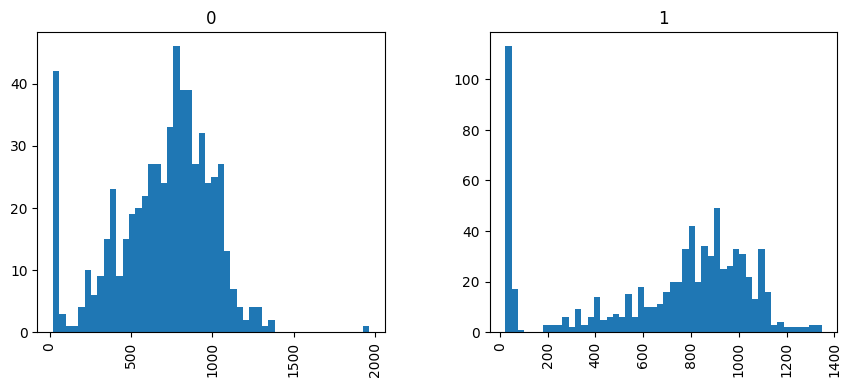

In [27]:
train.hist(column='LENGTH', by='LABEL_COLUMN', bins=50, figsize=(10,4))

In [28]:
train.pivot_table(index='LABEL_COLUMN',values='LENGTH',aggfunc='mean')

,LENGTH
LABEL_COLUMN,
0,695.364086
1,687.439314


  #### Word Cloud for Training Data
  - stopword removal hasn't done because bert handles them

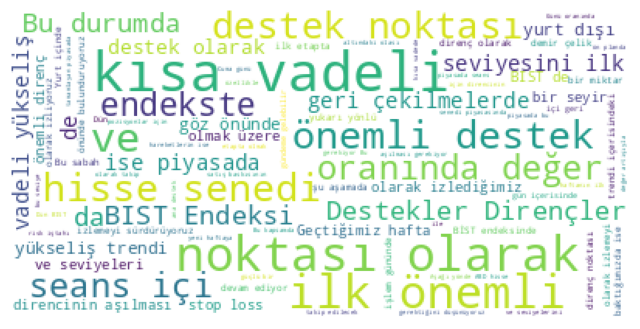

In [29]:
import wordcloud
wc = wordcloud.WordCloud(background_color='white', max_words=100, 
                         max_font_size=35)
wc = wc.generate(" ".join(train["DATA_COLUMN"].tolist()))
fig = plt.figure(num=1,figsize=(8,8))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

### Analysis for Training Data

In [32]:
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("iso-8859-9")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,Zayıf gelen tüketici güven endeksi verisi ve y...,1
1,Risk iştahında toparlanma. Dün itibariyle ABD ...,0
2,Bugün küresel piyasaların seyrini büyük ölçüde...,1
3,ABD'de dün açıklanan TÜFE verisinin ardından s...,1
4,"Haftaya başlarken 2,500 desteği kritik önemini...",1


In [33]:
test.groupby('LABEL_COLUMN').describe()

DATA_COLUMN         \
                   count unique   
LABEL_COLUMN                      
0                    157    153   
1                    184    171   

                                                                      
                                                            top freq  
LABEL_COLUMN                                                          
0             Haftanın öncelikli gündem maddesi konumundaki ...    3  
1             Haftaya güçlü bir başlangıç yapan BİST-100 end...    5

In [34]:
test['LENGTH'] = test['DATA_COLUMN'].apply(len)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

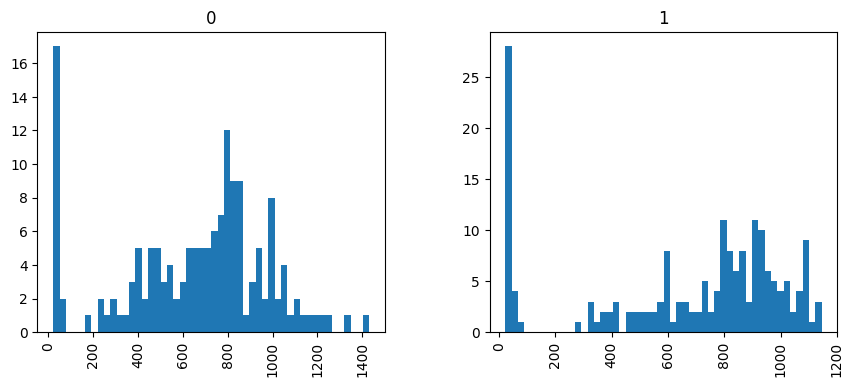

In [35]:
test.hist(column='LENGTH', by='LABEL_COLUMN', bins=50, figsize=(10,4))

In [36]:
test.pivot_table(index='LABEL_COLUMN',values='LENGTH',aggfunc='mean')

,LENGTH
LABEL_COLUMN,
0,653.834395
1,665.336957


#### Word Cloud for Test Data

- stopword removal hasn't done because bert handles them 



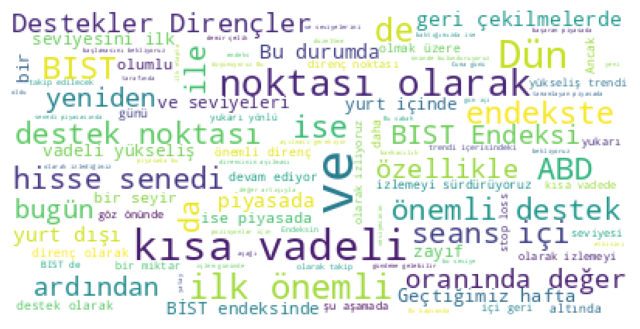

In [38]:
wc = wordcloud.WordCloud(background_color='white', max_words=100, 
                         max_font_size=35)
wc = wc.generate(" ".join(test["DATA_COLUMN"].tolist()))
fig = plt.figure(num=1,figsize=(8,8))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

### Model Training

In [12]:
#this will be used to give inputs
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [13]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [14]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

### Training Results
- We can see that our validation dataset has more than 90% accuracy

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy'),
                       ])

model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
86/86 [==============================] - 215s 1s/step - loss: 0.5162 - accuracy: 0.7308 - val_loss: 0.2985 - val_accuracy: 0.8768
Epoch 2/5
86/86 [==============================] - 96s 1s/step - loss: 0.2170 - accuracy: 0.9176 - val_loss: 0.3424 - val_accuracy: 0.8739
Epoch 3/5
86/86 [==============================] - 92s 1s/step - loss: 0.0664 - accuracy: 0.9769 - val_loss: 0.4075 - val_accuracy: 0.8944
Epoch 4/5
86/86 [==============================] - 97s 1s/step - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.4596 - val_accuracy: 0.9003
Epoch 5/5
86/86 [==============================] - 86s 1s/step - loss: 0.0159 - accuracy: 0.9956 - val_loss: 0.4323 - val_accuracy: 0.9003


In [48]:
# Extract sentences and true labels from the 'DATA_COLUMN' and 'LABEL_COLUMN' of the `test` dataframe
sentences = test['DATA_COLUMN'].tolist()
true_labels = test['LABEL_COLUMN'].tolist()

# Tokenize the input sentences
tf_batch = tokenizer(sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')

# Make predictions
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative', 'Positive']
predicted_labels = tf.argmax(tf_predictions, axis=1).numpy()

# Create a new DataFrame with the text value, true value, and predicted value
results_df = pd.DataFrame({'Text': sentences, 'True Value': true_labels, 'Predicted Value': predicted_labels})
results_df['Predicted Value'] = results_df['Predicted Value'].map(lambda x: labels[x])


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Map labels to 0 and 1 in the DataFrame
labels_mapping = {'Negative': 0, 'Positive': 1}
results_df['Predicted Value'] = results_df['Predicted Value'].map(labels_mapping)

# Calculate precision, recall, and F1 score
true_labels = results_df['True Value'].tolist()
predicted_labels = results_df['Predicted Value'].tolist()

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.89
Recall: 0.92
F1 Score: 0.91


### Visualizations to See the Performance

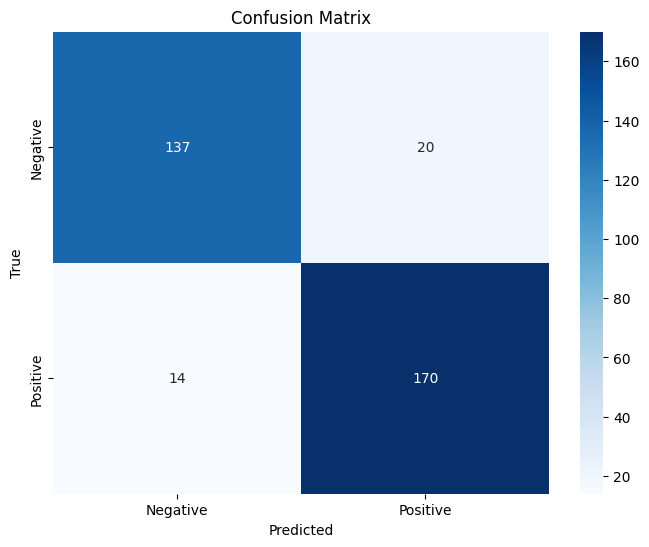

In [53]:
# Assuming you have the results_df DataFrame available
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
true_labels = results_df['True Value'].tolist()
predicted_labels = results_df['Predicted Value'].tolist()
confusion = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
confusion_df = pd.DataFrame(confusion, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

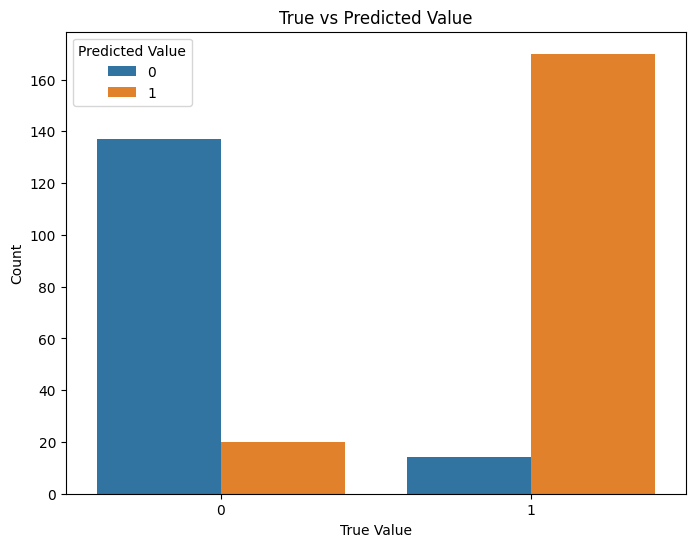

In [52]:
plt.figure(figsize=(8, 6))
sns.countplot(data=results_df, x='True Value', hue='Predicted Value')
plt.xlabel('True Value')
plt.ylabel('Count')
plt.title('True vs Predicted Value')
plt.show()

### Saving the trained model for later use

In [54]:
model.save('/content/drive/My Drive/Project_cs210/trained_model') 


In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/Project_cs210/trained_model")